In [15]:
import os, sys, json
from collections import Counter

In [16]:
SELECTED_INPUT_ID = "input_zeroshot_only-failed_edit"

### Getting all important json files

In [18]:

A4_DIR = "/home/anmola/assignments_hw/anlp_final_proj/outputs_A4"
# find all json files recursively in the directory
def find_json_files_in_dir(directory):
    json_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            # print(file)
            if file.endswith('.jsonl'):
                json_files.append(os.path.join(root, file))
    return json_files

json_files = find_json_files_in_dir(A4_DIR)

json_files = [x for x in json_files if "do_not_use" not in x]
json_files = [x for x in json_files if "DPO_NO" not in x]
json_files = [x for x in json_files if "profiler" not in x]
print("Total number of json files: ", len(json_files))

# here is the filename: generated_codes_deepseek_base_1e-4_NO_cot_speed_incorrect_samples_10_epoch_edit_deepseek_instruct_nrowsNone_tokens1024_temp0.0_fewshotex0_samples1_2024-12-08_00:33:24.jsonl 

# remove timestamp from the filename BUT retain the extension
def remove_timestamp_from_filename(filename):
    return filename.rsplit('_', 2)[0] + ".jsonl"


# read all the json files and map the filename to the data
inference_outputs_df = {}
judge_results_df = {}

for file in json_files:
    print(f"{file=}")
    file_category = "infer" if "inference_outputs" in file else "judge"

    if file_category == "infer":
        with open(file, 'r') as f:
            data = f.readlines()
            data = [json.loads(x) for x in data]
            inference_outputs_df[remove_timestamp_from_filename(os.path.basename(file))] = data
    else:
        with open(file, 'r') as f:
            data = json.load(f)
            _use_filename = remove_timestamp_from_filename(os.path.basename(file))
            _use_filename = _use_filename.replace("generated_codes_1_", "")
            _use_filename = _use_filename.replace("generated_codes_", "")
            judge_results_df[_use_filename] = data

print("Total number of inference files: ", len(inference_outputs_df))
print("Total number of judge files: ", len(judge_results_df))
assert(len(inference_outputs_df) == len(judge_results_df))

# get sorted base filenames
sorted_base_filenames = sorted(list(inference_outputs_df.keys()) + list(judge_results_df.keys()))
print("Total number of sorted base filenames: ", len(sorted_base_filenames))
print("Example sorted base filenames: ", *sorted_base_filenames, sep='\n')
# number of unique elements print
print("Number of unique elements in sorted_base_filenames: ", len(set(sorted_base_filenames)))
unique_sorted_base_filenames = set(sorted_base_filenames)


Total number of json files:  18
file='/home/anmola/assignments_hw/anlp_final_proj/outputs_A4/DPO_SPEED_AND_PASS1_FILTERING/judge_outputs/generated_codes_deepseek_base_1e-4_NO_cot_speed_incorrect_samples_10_epoch_edit_deepseek_instruct_nrowsNone_tokens1024_temp0.0_fewshotex0_samples1_2024-12-08_00:33:24.jsonl'
file='/home/anmola/assignments_hw/anlp_final_proj/outputs_A4/DPO_SPEED_AND_PASS1_FILTERING/judge_outputs/generated_codes_deepseek_base_1e-4_NO_cot_speed_incorrect_samples_10_epoch_edit_deepseek_instruct_nrowsNone_tokens1024_temp0.0_fewshotex2_samples1_2024-12-07_22:43:54.jsonl'
file='/home/anmola/assignments_hw/anlp_final_proj/outputs_A4/DPO_SPEED_AND_PASS1_FILTERING/judge_outputs/generated_codes_1_deepseek_base_1e-4_NO_cot_speed_incorrect_samples_10_epoch_self-refine_deepseek_instruct_nrowsNone_tokens1024_temp0.0_fewshotex0_samples1_2024-12-07_23:21:55.jsonl'
file='/home/anmola/assignments_hw/anlp_final_proj/outputs_A4/DPO_SPEED_AND_PASS1_FILTERING/inference_outputs/deepseek_base

#### Creating a map, which maps from jsonl file path to map-key name

In [19]:
assert(len(unique_sorted_base_filenames) == len(inference_outputs_df))


mapping_df = {x: "" for x in unique_sorted_base_filenames }

# with open("mapping.json", 'r') as f:
#     mapping_df = json.load(f)

for key in mapping_df:
    key_ans = []
    
    #######################
    list1 = ["fewshotex0", "fewshotex2"]
    # make sure atleast one is present
    assert(any(x in key for x in list1))
    if "fewshotex0" in key:
        key_ans.append("zeroshot")
    else:
        key_ans.append("fewshot")
    #############
    list2 = ["only_failed", "only_speed", "speed_incorrect"]
    # make sure atleast one is present
    assert(any(x in key for x in list2))
    if "only_failed" in key:
        key_ans.append("only-failed")
    elif "only_speed" in key:
        key_ans.append("only-speed")
    else:
        key_ans.append("speed-incorrect")
    ################
    list3 = ["edit", "self-refine"]
    # make sure atleast one is present
    assert(any(x in key for x in list3))
    if "edit" in key:
        key_ans.append("edit")
    else:
        key_ans.append("self-refine")
    #####
    final_key = "_".join(key_ans)
    mapping_df[key] = final_key


In [20]:
mapping_df

{'deepseek_base_1e-4_NO_cot_only_speed_samples_10_epoch_edit_deepseek_instruct_nrowsNone_tokens1024_temp0.0_fewshotex2_samples1.jsonl': 'fewshot_only-speed_edit',
 'deepseek_base_1e-4_NO_cot_speed_incorrect_samples_10_epoch_edit_deepseek_instruct_nrowsNone_tokens1024_temp0.0_fewshotex2_samples1.jsonl': 'fewshot_speed-incorrect_edit',
 'deepseek_base_1e-4_NO_cot_only_speed_samples_10_epoch_edit_deepseek_instruct_nrowsNone_tokens1024_temp0.0_fewshotex0_samples1.jsonl': 'zeroshot_only-speed_edit',
 'deepseek_base_1e-4_NO_cot_only_failed_samples_100_ckpt_self-refine_deepseek_instruct_nrowsNone_tokens1024_temp0.0_fewshotex0_samples1.jsonl': 'zeroshot_only-failed_self-refine',
 'deepseek_base_1e-4_NO_cot_only_speed_samples_10_epoch_self-refine_deepseek_instruct_nrowsNone_tokens1024_temp0.0_fewshotex0_samples1.jsonl': 'zeroshot_only-speed_self-refine',
 'deepseek_base_1e-4_NO_cot_speed_incorrect_samples_10_epoch_self-refine_deepseek_instruct_nrowsNone_tokens1024_temp0.0_fewshotex0_samples1.js

In [21]:
# make sure all unique_sorted_base_filenames are in mapping_df, raise error if not
for x in unique_sorted_base_filenames:
    if x not in mapping_df:
        print(f"Error: {x} not in mapping_df")
        raise ValueError

# replace the keys in inference_outputs_df and judge_results_df with the new keys
inference_outputs_df = {mapping_df[k]: v for k, v in inference_outputs_df.items()}
judge_results_df = {mapping_df[k]: v for k, v in judge_results_df.items()}

all_keys = set(inference_outputs_df.keys()) | set(judge_results_df.keys())
print("All keys: ", all_keys)
assert(all_keys == set(inference_outputs_df.keys()) == set(judge_results_df.keys()))
#######################
#### NOW START ASSEMBLING STUFF FOR ANALYSIS
# read each print keys in first element
# for key_now in all_keys:
#     print(f"{key_now=}")
#     print(f"{inference_outputs_df[key_now][0].keys()}")
#     print(f"{judge_results_df[key_now]['0'].keys()}")
#     print("\n########")

All keys:  {'zeroshot_speed-incorrect_edit', 'fewshot_only-speed_edit', 'zeroshot_only-failed_edit', 'zeroshot_only-speed_self-refine', 'fewshot_only-failed_edit', 'zeroshot_speed-incorrect_self-refine', 'fewshot_speed-incorrect_edit', 'zeroshot_only-failed_self-refine', 'zeroshot_only-speed_edit'}


#### What details to store about the code

In [22]:
class ModelCode:
    problem_id: str
    instance_id: int
    code_str: str
    passed_testcases_list: list
    error_trace: dict
    tc_list: list # has status ie passed or failed, time taken, error message, memory taken
    setting_id: str

In [23]:
def prep_output_object(code_str, problem_id, instance_id, setting_id, pass_list, runtime_map, memory_map, error_map):
    model_code = ModelCode()
    model_code.code_str = code_str
    model_code.problem_id = problem_id
    model_code.instance_id = instance_id
    model_code.setting_id = setting_id
    model_code.passed_testcases_list = sorted(pass_list) # list of ints
    failed_cases = [int(x) for x in error_map.keys()]
    # print("Number of passed testcases: ", len(model_code.passed_testcases_list))
    # print("Number of failed testcases: ", len(failed_cases))
    # print("Number of keys with runtime: ", len(runtime_map))
    # print("Number of keys with memory: ", len(memory_map))
    # make sure failed cases and passed cases are non-overlapping
    assert(len(set(failed_cases) & set(model_code.passed_testcases_list)) == 0)
    all_tests = set(failed_cases) | set(model_code.passed_testcases_list)
    all_tests = sorted(list(all_tests))
    # assert(all_tests == list(range(0, len(all_tests))))
    # keys in maps are string version of integers
    model_code.tc_list = []
    for tc_id in all_tests:
        if str(tc_id) in error_map:
            # assert(str(tc_id) not in runtime_map)
            # assert(str(tc_id) not in memory_map)
            model_code.tc_list.append({
                "tc_id": tc_id,
                "status": "failed",
                "time_taken": runtime_map.get(str(tc_id), None),
                "error_message": error_map[str(tc_id)],
                "memory_taken": memory_map.get(str(tc_id), None)    
            })
        else:
            assert(str(tc_id) in runtime_map)
            assert(str(tc_id) in memory_map)
            model_code.tc_list.append({
                "tc_id": tc_id,
                "status": "passed",
                "time_taken": runtime_map[str(tc_id)],
                "error_message": "",
                "memory_taken": memory_map[str(tc_id)]
            })
    return model_code

#### `instance_df` stores, for each instance, the details about code via different settings

In [24]:
instance_df = dict()

In [25]:
for setting_id in all_keys:
    print(f"{setting_id}")
    judge_elems = list(judge_results_df[setting_id].values())
    infer_elems = inference_outputs_df[setting_id]
    assert(len(judge_elems) == len(infer_elems))
    for instance_id, (infer_elem, judge_elem) in enumerate(zip(infer_elems, judge_elems)):
        assert(infer_elem['problem_id'] == judge_elem['problem_id'])
        code_prep_key = ["generated_codes", "generated_codes_0", "generated_codes_1", "generated_codes_2"]
        # find key which is latest in code_prep_key and still occurs in infer_elem
        code_str = None
        for key in code_prep_key:
            if key in infer_elem:
                code_str =key
                # break
        # print(f"{code_str=}")
        # output details
        infer_code_str = infer_elem[code_str][0]
        infer_problem_id = infer_elem['problem_id']
        infer_setting_id = "output_"+setting_id
        infer_instance_id = instance_id
        infer_pass_list = judge_elem['output_pass_all']
        infer_runtime_map = judge_elem['output_run_time_all']
        infer_memory_map = judge_elem['output_memory_all']
        infer_error_map = judge_elem['output_errors_all']
        infer_model_code = prep_output_object(infer_code_str, infer_problem_id, infer_instance_id, infer_setting_id, infer_pass_list, infer_runtime_map, infer_memory_map, infer_error_map)

        # input details
        input_code_str = infer_elem["input"]
        input_problem_id = infer_elem['problem_id']
        input_setting_id = "input_"+setting_id
        input_instance_id = instance_id
        input_pass_list = judge_elem['input_pass_all']
        input_runtime_map = judge_elem['input_run_time_all']
        input_memory_map = judge_elem['input_memory_all']
        input_error_map = judge_elem['input_errors_all']
        input_model_code = prep_output_object(input_code_str, input_problem_id, input_instance_id, input_setting_id, input_pass_list, input_runtime_map, input_memory_map, input_error_map)
        if instance_id not in instance_df:
            instance_df[instance_id] = dict()
        instance_df[instance_id][input_setting_id] = input_model_code
        instance_df[instance_id][infer_setting_id] = infer_model_code

        
        
        # break
    # break

zeroshot_speed-incorrect_edit
fewshot_only-speed_edit


zeroshot_only-failed_edit
zeroshot_only-speed_self-refine
fewshot_only-failed_edit
zeroshot_speed-incorrect_self-refine
fewshot_speed-incorrect_edit
zeroshot_only-failed_self-refine
zeroshot_only-speed_edit


In [26]:
instance_df

{0: {'input_zeroshot_speed-incorrect_edit': <__main__.ModelCode at 0x7fd7fef32af0>,
  'output_zeroshot_speed-incorrect_edit': <__main__.ModelCode at 0x7fd7fef32130>,
  'input_fewshot_only-speed_edit': <__main__.ModelCode at 0x7fd7fbe3ef40>,
  'output_fewshot_only-speed_edit': <__main__.ModelCode at 0x7fd7fbe3ef10>,
  'input_zeroshot_only-failed_edit': <__main__.ModelCode at 0x7fd7fb628df0>,
  'output_zeroshot_only-failed_edit': <__main__.ModelCode at 0x7fd7fb628dc0>,
  'input_zeroshot_only-speed_self-refine': <__main__.ModelCode at 0x7fd7fada0c40>,
  'output_zeroshot_only-speed_self-refine': <__main__.ModelCode at 0x7fd7fada0c10>,
  'input_fewshot_only-failed_edit': <__main__.ModelCode at 0x7fd7fa51fac0>,
  'output_fewshot_only-failed_edit': <__main__.ModelCode at 0x7fd7fa51fa90>,
  'input_zeroshot_speed-incorrect_self-refine': <__main__.ModelCode at 0x7fd7f9ff4040>,
  'output_zeroshot_speed-incorrect_self-refine': <__main__.ModelCode at 0x7fd7fa005fa0>,
  'input_fewshot_speed-incorrec

#### Make sure that for same problem, for input based settings, set of passed and failed test cases is same

In [27]:
for instance_id in instance_df:
    # print(f"{instance_id=}")
    # print(f"{instance_df[instance_id].keys()}")
    # print("\n########")
    all_input_settings = [x for x in instance_df[instance_id].keys() if "input" in x]
    passed_list = None
    all_tests  = None
    for setting_id in all_input_settings:
        setting_passed_list = instance_df[instance_id][setting_id].passed_testcases_list
        setting_all_tests = [x['tc_id'] for x in instance_df[instance_id][setting_id].tc_list]
        if passed_list is None:
            passed_list = set(setting_passed_list)
            all_tests = set(setting_all_tests)
        else:
            # make sure equal
            assert(passed_list == set(setting_passed_list))
            assert(all_tests == set(setting_all_tests))

In [28]:
## Calculate pass rates
pass_rate_df = dict()
for instance_id in instance_df:
    # print(f"{instance_id=}")
    # make sure that size of "tc_list" is same for all settings for a given instance
    all_settings = instance_df[instance_id].keys()
    all_settings = sorted(all_settings)
    num_cases = None
    all_cases = []
    for setting_id in all_settings:
        all_cases.extend([x['tc_id'] for x in instance_df[instance_id][setting_id].tc_list])
    all_cases = sorted(list(set(all_cases)))
    num_cases = len(all_cases)
    for setting_id in all_settings:
        if setting_id not in pass_rate_df:
            pass_rate_df[setting_id] = dict()
        pass_rate_df[setting_id][instance_id] = dict()
        pass_rate_df[setting_id][instance_id]['pass_rate'] = len(instance_df[instance_id][setting_id].passed_testcases_list) / num_cases
        pass_rate_df[setting_id][instance_id]['num_passed'] = len(instance_df[instance_id][setting_id].passed_testcases_list)
        pass_rate_df[setting_id][instance_id]['num_failed'] = num_cases - len(instance_df[instance_id][setting_id].passed_testcases_list)

        # find memory speed-ups and time-speed ups
        tc_ids_aim = instance_df[instance_id][SELECTED_INPUT_ID].passed_testcases_list
        tc_ids_passed_in_current_setting =instance_df[instance_id][setting_id].passed_testcases_list
        tc_ids_aim = [x for x in tc_ids_aim if x in tc_ids_passed_in_current_setting]
        # assert(len(tc_ids_aim)!=0)
        sum_input_time = 0
        sum_model_code_time = 0
        sum_input_memory = 0
        sum_model_code_memory = 0
        for check_tc_id in tc_ids_aim:
            wanted_input_elem = [x for x in instance_df[instance_id][SELECTED_INPUT_ID].tc_list if x['tc_id'] == check_tc_id]
            wanted_model_code_elem = [x for x in instance_df[instance_id][setting_id].tc_list if x['tc_id'] == check_tc_id]
            assert(len(wanted_input_elem) == 1)
            assert(len(wanted_model_code_elem) == 1)
            sum_input_time += wanted_input_elem[0]['time_taken']
            sum_model_code_time += wanted_model_code_elem[0]['time_taken']
            sum_input_memory += wanted_input_elem[0]['memory_taken']
            sum_model_code_memory += wanted_model_code_elem[0]['memory_taken']
        pass_rate_df[setting_id][instance_id]['time_speed_up'] = sum_input_time / sum_model_code_time if sum_model_code_time != 0 else 0
        pass_rate_df[setting_id][instance_id]['memory_speed_up'] = sum_input_memory / sum_model_code_memory if sum_model_code_memory != 0 else 0

        

In [29]:
instance_df[instance_id][SELECTED_INPUT_ID].passed_testcases_list

[0, 1, 2, 10, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26]

In [30]:
Counter([x['pass_rate'] for x in pass_rate_df[SELECTED_INPUT_ID].values()])

Counter({1.0: 638,
         0.7: 90,
         0.85: 9,
         0.9: 8,
         0.95: 7,
         0.8: 7,
         0.75: 6,
         0.5: 5,
         0.55: 5,
         0.6: 5,
         0.3: 3,
         0.65: 3,
         0.2: 2,
         0.35: 2,
         0.8333333333333334: 1,
         0.4: 1,
         0.25: 1,
         0.15: 1})

In [31]:
--------------

SyntaxError: invalid syntax (3984577744.py, line 1)

In [32]:
pass_rate_df = {k: v.values() for k, v in pass_rate_df.items()}

In [33]:
pass_rate_df

{'input_fewshot_only-failed_edit': dict_values([{'pass_rate': 0.85, 'num_passed': 17, 'num_failed': 3, 'time_speed_up': 1.0106951871657754, 'memory_speed_up': 0.9372972972972973}, {'pass_rate': 1.0, 'num_passed': 20, 'num_failed': 0, 'time_speed_up': 1.04, 'memory_speed_up': 1.0017131669114048}, {'pass_rate': 0.85, 'num_passed': 17, 'num_failed': 3, 'time_speed_up': 1.0, 'memory_speed_up': 1.0026442140421683}, {'pass_rate': 0.85, 'num_passed': 17, 'num_failed': 3, 'time_speed_up': 1.0174418604651163, 'memory_speed_up': 1.0052516120454698}, {'pass_rate': 1.0, 'num_passed': 20, 'num_failed': 0, 'time_speed_up': 1.017094017094017, 'memory_speed_up': 1.000591048304766}, {'pass_rate': 0.7, 'num_passed': 14, 'num_failed': 6, 'time_speed_up': 1.024390243902439, 'memory_speed_up': 0.994059578928977}, {'pass_rate': 1.0, 'num_passed': 20, 'num_failed': 0, 'time_speed_up': 1.009049773755656, 'memory_speed_up': 1.003239266498298}, {'pass_rate': 1.0, 'num_passed': 20, 'num_failed': 0, 'time_speed_u

In [34]:
import pandas as pd
import numpy as np

# Create a list to store the data
data = []

# Iterate through the pass_rate_df dictionary and collect the data
for setting_now in pass_rate_df:
    tot_tests = len(pass_rate_df[setting_now])
    all_passed_rate = len([x for x in pass_rate_df[setting_now] if x['pass_rate'] == 1]) / tot_tests
    avg_pass_rate = sum([x['pass_rate'] for x in pass_rate_df[setting_now]]) / tot_tests
    avg_time_speed_up = np.mean([x['time_speed_up'] for x in pass_rate_df[setting_now]])
    avg_memory_speed_up = np.mean([x['memory_speed_up'] for x in pass_rate_df[setting_now]])
    std_time_speedup = np.std([x['time_speed_up'] for x in pass_rate_df[setting_now]])
    std_memory_speedup = np.std([x['memory_speed_up'] for x in pass_rate_df[setting_now]])
    data.append([setting_now, all_passed_rate, avg_pass_rate, avg_time_speed_up, avg_memory_speed_up, std_time_speedup, std_memory_speedup])

# Create a dataframe
df = pd.DataFrame(data, columns=['Setting', 'All Passed Rate', 'Average Passed Rate', 'Average Time Speed Up', 'Average Memory Speed Up', 'Std Time Speed Up', 'Std Memory Speed Up'])

# Display the dataframe
df


,Setting,All Passed Rate,Average Passed Rate,Average Time Speed Up,Average Memory Speed Up,Std Time Speed Up,Std Memory Speed Up
0,input_fewshot_only-failed_edit,0.803526,0.940092,1.006231,1.000131,0.018284,0.005332
1,input_fewshot_only-speed_edit,0.803526,0.940092,1.036582,0.999458,0.026333,0.004485
2,input_fewshot_speed-incorrect_edit,0.803526,0.940092,1.111889,0.998671,0.046031,0.004838
3,input_zeroshot_only-failed_edit,0.803526,0.940092,1.000000,1.000000,0.000000,0.000000
4,input_zeroshot_only-failed_self-refine,0.803526,0.940092,1.008508,0.999820,0.017934,0.005049
5,input_zeroshot_only-speed_edit,0.803526,0.940092,1.040854,0.999486,0.028907,0.004481
6,input_zeroshot_only-speed_self-refine,0.803526,0.940092,1.115139,0.998565,0.047660,0.005629
7,input_zeroshot_speed-incorrect_edit,0.803526,0.940092,1.062588,0.999627,0.033022,0.005092
8,input_zeroshot_speed-incorrect_self-refine,0.803526,0.940092,1.092455,0.998988,0.039173,0.005069
9,output_fewshot_only-failed_edit,0.539043,0.666352,0.985475,0.941629,3.134241,3.284860


#### For an instance, take performance of 2 methods on different testcases of the instance, and find win-rate

In [35]:
# find win rate
# take 2 tc_list
def find_win_rate(tc_list1, tc_list2):
    # assert(len(tc_list1) == len(tc_list2))
    win_1 = 0
    win_2 = 0
    tied = 0
    tc_1_dict = {x['tc_id']: x for x in tc_list1}
    tc_2_dict = {x['tc_id']: x for x in tc_list2}
    all_tcs = set(tc_1_dict.keys()) & set(tc_2_dict.keys())
    if len(all_tcs) == 0:
        return 0, 0, 1
    for tc in all_tcs:
        elem_1 = tc_1_dict[tc]
        elem_2 = tc_2_dict[tc]
        # if both failed, continue
        if elem_1['status'] == "failed" and elem_2['status'] == "failed":
            continue
        # if only one passed, then increment win-rate accordingly
        if elem_1['status'] == "passed" and elem_2['status'] == "failed":
            win_1 += 1
        elif elem_1['status'] == "failed" and elem_2['status'] == "passed":
            win_2 += 1
        if elem_1['status'] == "passed" and elem_2['status'] == "passed":
            if elem_1['time_taken'] < elem_2['time_taken']:
                win_1 += 1
            elif elem_1['time_taken'] > elem_2['time_taken']:
                win_2 += 1
            else:
                tied += 1
    win_1/=len(all_tcs)
    win_2/=len(all_tcs)
    tied/=len(all_tcs)
    return win_1, win_2, tied

### `win_rate_df` stores, for each <instance, method_1, method_2>, the corresponding win-rate

In [36]:
# find win rate for each with the other
win_rate_df = dict()
for instance_id in instance_df:
    all_settings = instance_df[instance_id].keys()
    all_settings = sorted(all_settings)
    all_settings = [x for x in all_settings if ("input" not in x) or (x==SELECTED_INPUT_ID)]
    for setting_id in all_settings:
        if setting_id not in win_rate_df:
            win_rate_df[setting_id] = dict()
        for setting_id2 in all_settings:
            if setting_id2 not in win_rate_df[setting_id]:
                win_rate_df[setting_id][setting_id2] = []
            win_1, win_2, tied = find_win_rate(instance_df[instance_id][setting_id].tc_list, instance_df[instance_id][setting_id2].tc_list)
            win_rate_df[setting_id][setting_id2].append(win_1)

#### `average_win_df` stores, for each <method_1, method_2>, the average win-rate for method_1 with method_2 across all instances

In [37]:
avg_win_df = dict()
for curr_setting_1 in win_rate_df:
    print("@@@@@@@@@@@@@@@@@@@@@@@@")
    print(f"{curr_setting_1=}")
    for curr_setting_2 in win_rate_df[curr_setting_1]:
        # print(f"{curr_setting_1} vs {curr_setting_2}")
        avg_wins = sum(win_rate_df[curr_setting_1][curr_setting_2])/len(win_rate_df[curr_setting_1][curr_setting_2])
        print(f"{setting_id} {avg_wins=}")
        if curr_setting_1 not in avg_win_df:
            avg_win_df[curr_setting_1] = dict()
        avg_win_df[curr_setting_1][curr_setting_2] = avg_wins
        print("\n########")

@@@@@@@@@@@@@@@@@@@@@@@@
curr_setting_1='input_zeroshot_only-failed_edit'
output_zeroshot_speed-incorrect_self-refine avg_wins=0.0

########
output_zeroshot_speed-incorrect_self-refine avg_wins=0.3348026868178003

########
output_zeroshot_speed-incorrect_self-refine avg_wins=0.41947942905121754

########
output_zeroshot_speed-incorrect_self-refine avg_wins=0.3872795969773299

########
output_zeroshot_speed-incorrect_self-refine avg_wins=0.42567280922709827

########
output_zeroshot_speed-incorrect_self-refine avg_wins=0.6282765737874086

########
output_zeroshot_speed-incorrect_self-refine avg_wins=0.5329068893897209

########
output_zeroshot_speed-incorrect_self-refine avg_wins=0.6739425983836442

########
output_zeroshot_speed-incorrect_self-refine avg_wins=0.5004551681470676

########
output_zeroshot_speed-incorrect_self-refine avg_wins=0.651462724822129

########
@@@@@@@@@@@@@@@@@@@@@@@@
curr_setting_1='output_fewshot_only-failed_edit'
output_zeroshot_speed-incorrect_self-refine av

In [38]:
avg_wins

0.0

In [ ]:
len(win_rate_df)

In [ ]:
avg_win_df

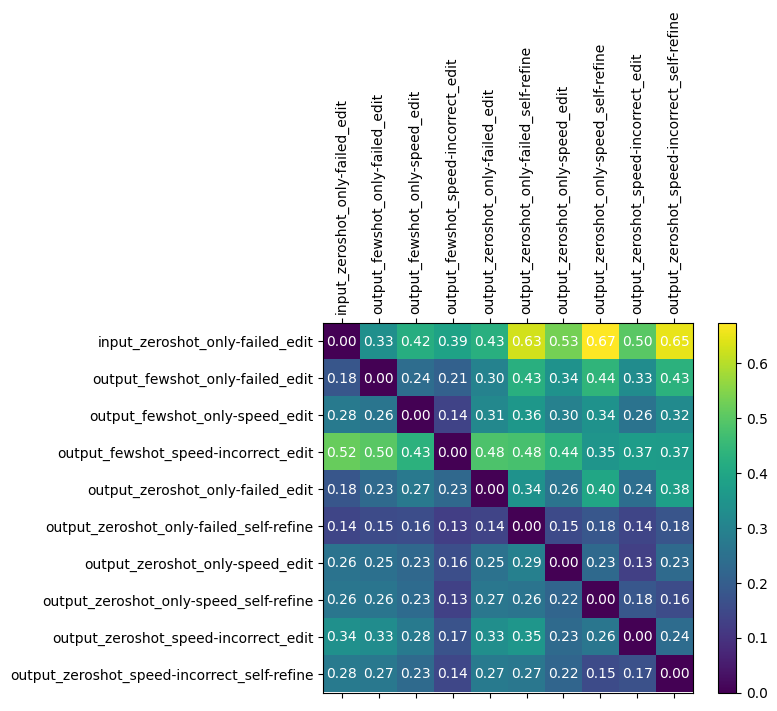

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Convert dictionary to numpy array
rows = list(avg_win_df.keys())
cols = list(next(iter(avg_win_df.values())).keys())
data = np.array([[avg_win_df[row][col] for col in cols] for row in rows])

# Create the heatmap
fig, ax = plt.subplots()
cax = ax.matshow(data, cmap='viridis')

# Add colorbar
fig.colorbar(cax)

# Set axis labels
ax.set_xticks(range(len(cols)))
ax.set_yticks(range(len(rows)))
ax.set_xticklabels(cols, rotation=90)
ax.set_yticklabels(rows)

# Add text annotations with 2 decimal places
for i in range(len(rows)):
    for j in range(len(cols)):
        ax.text(j, i, f"{data[i, j]:.2f}", ha='center', va='center', color='white')

plt.show()